In [ ]:
import os
import sys
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import dates as mdates
from lmu_meteo_api import interface
import polars as pl
import numpy as np
from datetime import datetime

PROJECT_PATH = os.path.abspath(os.path.join("..", ".."))
PIPELINE_PATH = os.path.join(PROJECT_PATH, "pipeline")
DATA_DIRECTORY = os.path.join(PROJECT_PATH, "data")

if PIPELINE_PATH not in sys.path:
    sys.path.append(PIPELINE_PATH)
    
from utils.paths import POSTPROCESSED_DATA_DIRECTORY
from utils.import_data import import_acropolis_system_data

assert(os.path.exists(DATA_DIRECTORY))
assert(os.path.exists(POSTPROCESSED_DATA_DIRECTORY))

In [2]:
#functions
def get_lmu_data(start_date:datetime, end_date:datetime, station_id = 'MIM01'):
    
    start_date = start_date.strftime("%Y-%m-%dT%H-%M-%S")
    end_date = end_date.strftime("%Y-%m-%dT%H-%M-%S")

    parameters = ["air_temperature_30m"]

    # download from the API
    lmu_api = interface.meteo_data()
    data = lmu_api.get_meteo_data(parameters=parameters, 
                                station_id= station_id, 
                                start_time=start_date, 
                                end_time=end_date)
    
    df_lmu = pl.from_pandas(data, include_index = True) \
    .rename({"time": "datetime"}) \
    .with_columns(pl.col("datetime").dt.cast_time_unit("ms")) \
    .with_columns(pl.col("air_temperature_30m") -273.15) \
    .with_columns(
            pl.lit(f"lmu meteo").alias("system_name")
        ) \
    .sort("datetime") \
    .group_by_dynamic("datetime", every='1h', group_by= "system_name")  \
    .agg(pl.all().exclude(["datetime","system_name"]).mean())
    
    del data
        
    return df_lmu

In [3]:
def insert_nan_gaps(x, y, max_gap_minutes=60):
    x = np.array(x)
    y = np.array(y)
    x_diff = np.diff(x).astype("timedelta64[m]").astype(int)
    gap_indices = np.where(x_diff > max_gap_minutes)[0] + 1

    x_new = []
    y_new = []

    prev_idx = 0
    for gap_idx in gap_indices:
        x_new.extend(x[prev_idx:gap_idx])
        y_new.extend(y[prev_idx:gap_idx])
        # insert NaN to break the line
        x_new.append(x[gap_idx-1] + (x[gap_idx] - x[gap_idx-1]) / 2)
        y_new.append(np.nan)
        prev_idx = gap_idx

    x_new.extend(x[prev_idx:])
    y_new.extend(y[prev_idx:])

    return np.array(x_new), np.array(y_new)

In [7]:
# Filters
start_date = datetime(2025, 2, 18, 0, 0, 0)
end_date = datetime(2025, 5, 31, 0, 0, 0)

filter = '1h'
ids = [3,6]

# Load ACROPOLIS Data
all_systems = []

for id in ids:
    df_system = import_acropolis_system_data(
            years=[2024,2025],
            target_directory=POSTPROCESSED_DATA_DIRECTORY,
            id=id,
            prefix="1min"
        ).group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean()) \
        .filter(pl.col("datetime").is_between(start_date, end_date))
        
    all_systems.append(df_system)
    
del df_system
df_1 = pl.concat(all_systems, how="diagonal").collect()
df_1.head(1).vstack(df_1.tail(1))

# remove data point
df_1 = df_1.filter(pl.col("datetime") != datetime(2025, 5, 5, 9, 0, 0))

In [8]:
df_lmu_1 = get_lmu_data(start_date, end_date, station_id='MIM01')
df_lmu_1.head(1).vstack(df_lmu_1.tail(1))

system_name,datetime,air_temperature_30m
str,datetime[ms],f64
"""lmu meteo""",2025-02-18 00:00:00,-2.2835
"""lmu meteo""",2025-05-31 00:00:00,16.93


In [9]:
# Filters
start_date = datetime(2025, 6, 6, 0, 0, 0)
end_date = datetime(2025, 7, 7, 0, 0, 0)

filter = '1h'
ids = [3,6]

# Load ACROPOLIS Data
all_systems = []

for id in ids:
    df_system = import_acropolis_system_data(
            years=[2024,2025],
            target_directory=POSTPROCESSED_DATA_DIRECTORY,
            id=id,
            prefix="1min"
        ).group_by_dynamic("datetime", every=filter, group_by=["system_id", "system_name"]) \
            .agg(cs.numeric().mean()) \
        .filter(pl.col("datetime").is_between(start_date, end_date))
        
    all_systems.append(df_system)
    
del df_system
df_2 = pl.concat(all_systems, how="diagonal").collect()
df_2.head(1).vstack(df_2.tail(1))

system_id,system_name,datetime,ts,gmp343_raw,gmp343_compensated,gmp343_filtered,gmp343_temperature,bme280_temperature,bme280_humidity,bme280_pressure,sht45_temperature,sht45_humidity,gmp343_edge_corrected,gmp343_edge_dry,h2o_v%,gmp343_dry,slope,intercept,slope_interpolated,intercept_interpolated,gmp343_corrected,wxt532_direction_min,wxt532_direction_avg,wxt532_direction_max,wxt532_speed_min,wxt532_speed_avg,wxt532_speed_max,wxt532_last_update_time,wxt532_temperature,wxt532_heating_voltage,wxt532_supply_voltage,wxt532_reference_voltage,enclosure_bme280_temperature,enclosure_bme280_humidity,enclosure_bme280_pressure,raspi_cpu_temperature,raspi_disk_usage,raspi_cpu_usage,raspi_memory_usage,ups_powered_by_grid,ups_battery_is_fully_charged,ups_battery_error_detected,ups_battery_above_voltage_threshold,cal_gmp343_slope,cal_gmp343_intercept,cal_sht_45_offset
i32,str,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
3,"""acropolis-3""",2025-06-06 00:00:00,1.7492e12,384.086833,460.629667,460.797222,42.603333,39.606122,15.409861,937.484489,39.80891,20.445098,452.903833,469.472333,1.847976,469.472964,0.983442,-13.776145,0.994444,-17.297751,449.566915,null,null,null,null,null,null,null,null,null,null,null,26.6995,34.940167,953.8565,48.031667,0.325,0.02095,0.082433,1.0,1.0,0.0,1.0,null,null,null
6,"""acropolis-6""",2025-07-07 00:00:00,1.7518e12,353.606667,407.221944,407.180278,30.884722,27.089333,39.474111,933.840444,27.221333,42.34057,435.620556,415.600833,2.025557,415.598502,1.040994,2.881741,1.040994,2.881741,435.51727,159.05,268.046667,328.3,0.613333,1.981667,3.848333,1.7518e9,null,null,null,null,34.299667,24.001333,946.6775,54.775,0.338,0.01815,0.073817,1.0,1.0,0.0,1.0,1.0311,7.1,1.54


In [10]:
df_lmu_2 = get_lmu_data(start_date, end_date, station_id='MIM01')
df_lmu_2.head(1).vstack(df_lmu_2.tail(1))

system_name,datetime,air_temperature_30m
str,datetime[ms],f64
"""lmu meteo""",2025-06-06 00:00:00,15.74
"""lmu meteo""",2025-07-07 00:00:00,15.37


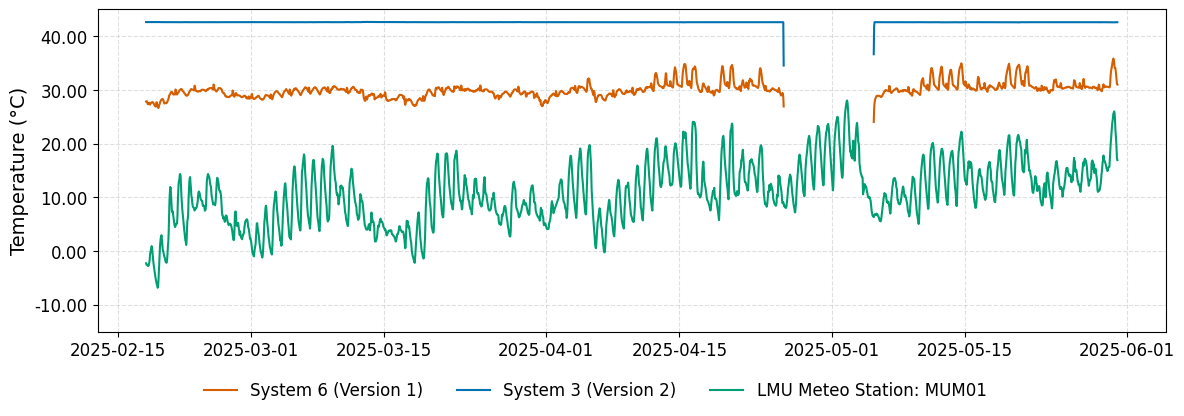

In [12]:
y_col_name = "gmp343_temperature"
y_title = "Temperature (°C)"
figsize = (12, 4)
dpi = 100
n_rows = 1
n_cols = 1
system_id = 3


fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=figsize, dpi=dpi,
                            sharex=False, sharey=True)
axes = np.array(axes).reshape(n_rows, n_cols)

# First plot
row, col = divmod(0, n_cols)
ax = axes[row, col]

# System 6
system_id = 6

df_sys = df_1.filter(pl.col("system_id") == system_id)

x = df_sys.get_column("datetime").to_numpy()
y = df_sys.get_column(y_col_name).to_numpy()

x, y = insert_nan_gaps(x, y, max_gap_minutes=60)

# Scatter
ax.plot(x, y, color="#D55E00", alpha=1, label=f"System {system_id} (Version 1)")

# System 3
system_id = 3

df_sys = df_1.filter(pl.col("system_id") == system_id)
x = df_sys.get_column("datetime").to_numpy()
y = df_sys.get_column(y_col_name).to_numpy()

x, y = insert_nan_gaps(x, y, max_gap_minutes=60)

# Scatter
ax.plot(x, y,color="#0072B2", alpha=1, label=f"System {system_id} (Version 2)")

# LMU
x = df_lmu_1.get_column("datetime").to_numpy()
y = df_lmu_1.get_column("air_temperature_30m").to_numpy()

# Scatter
ax.plot(x, y, color="#009E73", alpha=1, label=f"LMU Meteo Station: MUM01")

ax.set_ylabel(y_title, fontsize=14)

y_lim = (-10, 45)
ax.set_ylim(y_lim)

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.grid(True, linestyle='--', alpha=0.4)

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=False,
    fontsize=12,
)
y_lim = (-15, 45)
ax.set_ylim(y_lim)

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.xaxis.get_majorticklabels(),  fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

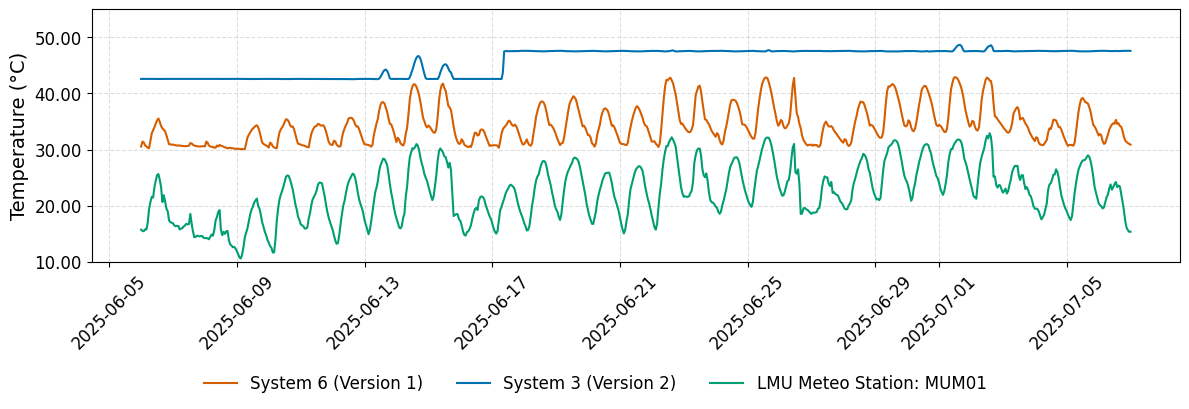

In [13]:
y_col_name = "gmp343_temperature"
y_title = "Temperature (°C)"
figsize = (12, 4)
dpi = 100
n_rows = 1
n_cols = 1
system_id = 3


fig, axes = plt.subplots(n_rows, n_cols,
                            figsize=figsize, dpi=dpi,
                            sharex=False, sharey=True)
axes = np.array(axes).reshape(n_rows, n_cols)

# First plot
row, col = divmod(0, n_cols)
ax = axes[row, col]

# System 6
system_id = 6

df_sys = df_2.filter(pl.col("system_id") == system_id)

x = df_sys.get_column("datetime").to_numpy()
y = df_sys.get_column(y_col_name).to_numpy()

x, y = insert_nan_gaps(x, y, max_gap_minutes=60)

# Scatter
ax.plot(x, y, color="#D55E00", alpha=1, label=f"System {system_id} (Version 1)")

# System 3
system_id = 3

df_sys = df_2.filter(pl.col("system_id") == system_id)
x = df_sys.get_column("datetime").to_numpy()
y = df_sys.get_column(y_col_name).to_numpy()

x, y = insert_nan_gaps(x, y, max_gap_minutes=60)

# Scatter
ax.plot(x, y,color="#0072B2", alpha=1, label=f"System {system_id} (Version 2)")

# LMU
x = df_lmu_2.get_column("datetime").to_numpy()
y = df_lmu_2.get_column("air_temperature_30m").to_numpy()

# Scatter
ax.plot(x, y, color="#009E73", alpha=1, label=f"LMU Meteo Station: MUM01")

ax.set_ylabel(y_title, fontsize=14)

y_lim = (-10, 45)
ax.set_ylim(y_lim)

ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
ax.grid(True, linestyle='--', alpha=0.4)

fig.legend(
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
    frameon=False,
    fontsize=12,
)
y_lim = (10, 55)
ax.set_ylim(y_lim)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.setp(ax.xaxis.get_majorticklabels(),  fontsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.xticks(rotation=45)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()